# Gas Cooled Reactor Practice

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

In [2]:
# fuel materials from er362_omc > examples > microreactor > haleu_gcr > pf0p3

# HALEU in triso particles in graphite matrix
# packing factor = 0.3
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3732e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.11720e-4)
fuel.add_nuclide('U238',8.5221e-4)
fuel.add_element('C',7.7953e-2)
fuel.add_element('O',2.1279e-3)
fuel.add_element('S',2.5875e-3)
fuel.add_s_alpha_beta('c_Graphite')
fuel.depletable = True


coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.58

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = mod
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();

colors = {}
colors[fuel]='yellow'
colors[mod]='grey'
colors[coolant]='pink'

In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();


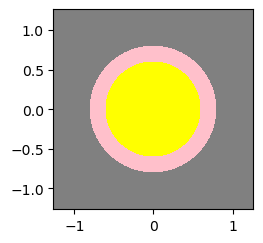

In [5]:
root_univ.plot(width=(pitch,pitch),pixels=[200,200],color_by='material',colors=colors);

In [6]:
plot = openmc.Plot()
plot.filename = 'HALEU_GCR'
plot.width = (pitch, pitch)
plot.pixels = (400, 400)
plot.color_by = 'material'
plot.colors = {fuel: 'yellow', coolant: 'blue', mod: 'grey'}

plots = openmc.Plots([plot])
plots.export_to_xml()
openmc.plot_geometry()
!convert model3.ppm model3.png


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

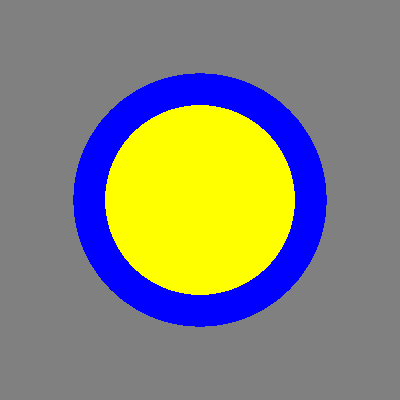

In [7]:
from IPython.display import Image
Image("HALEU_GCR.png")


In [8]:
import os

num_threads_des = 24  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS

openmc.run(threads = num_threads)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
model = openmc.model.Model(geometry,materials,settings)
operator = openmc.deplete.CoupledOperator(model,"chain_endfb71_pwr.xml");

# typical PWR power density
full_pd = 20.0; # W/gHM, estimate
power_density = [full_pd,full_pd,full_pd,full_pd,full_pd,
                full_pd,full_pd,full_pd,full_pd,full_pd,
                0,0,0,0,0]; # power density W/gHM 
# power 0 after 4.5 years with cooldown steps of a day, week, month to 2 years
days = 24*3600;
time_steps = [0.5*days,0.5*days,1*days,5*days,
              23*days,150*days,365*days,365*days,
              365*days,365*days,
              1*days,6*days,23*days,335*days,365*days];
cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);

repeat_depletion = False


if(repeat_depletion):
    cecm.integrate()


In [ ]:
# get depletion results to manipulate
r = openmc.deplete.Results('depletion_results.h5')
burned_mats = r.export_to_materials(burnup_index=15)
burned_mats.export_to_xml('BurnedMaterials15.xml')


In [ ]:
print(burned_mats)


In [ ]:
mat_tree = et.parse('BurnedMaterials15.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='fuel_compact':
        uo2_elem = root[i]
    i+=1

In [ ]:
# create Material object from element in burned Materials object
uo2_elem.set('id',23)
print(uo2_elem.items())
type(uo2_elem)
burned_uo2 = openmc.Material.from_xml_element(uo2_elem)
burned_uo2_mass = burned_uo2.get_mass()

#burned_uo2 = openmc.Material(name='burned_uo2')
#Burned_uo2 = burned_uo2.from_xml_element(uo2_elem)
print(burned_uo2)
print(burned_uo2_mass)


In [ ]:
listnuc = burned_uo2.get_nuclides() # list of nuclides present in burned fuel

In [ ]:
# get string with all Pu isotopes present in burned fuel
# isotopes that will be present after chemical processing
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)

In [ ]:
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_uo2.get_mass(nuclide=nuclide)
print(pu_mass)

In [ ]:
pu_mass_fraction = pu_mass/burned_uo2_mass
print(pu_mass_fraction)


In [ ]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium
print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_uo2.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
print(BurnPuAo)
print(SepPu)


In [ ]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geometry,materials,settings)
    
    return model

In [ ]:
# get activity from burned fuel
print('Target material activity is %5.3g Bq/g ' % burned_uo2.get_activity())
burnact = burned_uo2.get_activity(units='Bq/g',by_nuclide=True)
print(burnact)

In [ ]:
net_weight_HALEU = BCM/pu_mass_fraction
print(net_weight_HALEU,' kg') # in kg only fuel material (no clad)

In [ ]:
total_spec_act = sum(burnact.values()) 
totalact = total_spec_act*net_weight_HALEU/(3.7e7) # total activity from nuclear fuel required for one BCM (Ci)
print(totalact,' Ci')
